# <font color='blue'>REPORT FOR DIRECT MARKET OPTIMIZATION</font>
<div class="alert alert-block alert-info">
<b>Source:</b> Data and meta data obtained from KBC bank in relation to data science interview
</div>

Prior to coming up with the structure of the analysis, there was an intense brainstorm on the business problem to be in order to have a full understanding of it. The data set sent was in excel work sheet format and had 5 sheets. The sheets had the following information:
1. Meta data with information of each feature
2. Social demographic information
3. Products owned and Actual volumes for current accounts, saving accounts, mutual funds, overdraft, credit card and consumer loan
4. Inflow and Outflow on C/A and aggregated card turnover

**STRUCTURE OF ANALYSIS**

**I. Loading of libraries for analysis**

**II. Creation of Analytical data set**

**III. Exploratory analysis**
1. Distribution summary
2. Data visualization

**IV. Preprocessing**
1. Featuring engineering and data transformation
2. Feature selection

**V. Model building**
1. Consumer loan
     1. Propensity model for consumer loan (full and reduced models)
     2. Revenue model for consumer loan (full and reduced models)
2. Credit card
     1. Propensity model for credit card (full and reduced models)
     2. Revenue model for credit card (full and reduced models)
3. Mutual fund
     1. Propensity model for mutual fund (full and reduced models)
     2. Revenue model for mutual fund (full and reduced models)

**VI. Target clients**


# LOADING OF LIBRARIES FOR ANALYSIS

In [2]:
#To eliminate warnings from the outputs
import warnings
warnings.filterwarnings("ignore")

#Libraries for data manipulation
import pandas as p
from numpy import nan
import statistics
from sklearn.preprocessing import scale
import numpy as np
from collections import Counter
from sklearn import preprocessing
from itertools import compress
import math

#Libraries for machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

#Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# CREATION OF ANALYTICAL DATA SET

In this section, the datasets(Social-demographical,Products owned + actual volumes ,Inflow/outflow on C/A, aggregated card turnover and sales & revenue data) were loaded into the notebook. The data sets were merged into train and target sets. Quality control was performed to ensure that 60% of clients had sales and revenue information and 40% of clients without.

In [3]:
#Importing excel sheet with all data information
xls = p.ExcelFile('C:/Users/eugen/Desktop/Work/KBC bank/Task_Data_Scientist_Dataset.xlsx')

#Social-demographical data
data_SD=p.read_excel(xls,'Soc_Dem')

#Products owned + actual volumes
data_PAB=p.read_excel(xls,'Products_ActBalance')

#Inflow/outflow on C/A, aggregated card turnover
data_IOF=p.read_excel(xls,'Inflow_Outflow')

#For 60 % of clients actual sales + revenues from these are available
response_df=p.read_excel(xls,'Sales_Revenues')

In [11]:
print("Number of labeled clients: ",len(response_df))

Number of labeled clients:  969


In [8]:
print(len(data_SD), " clients have social demographic information")
print(len(data_PAB), " clients have Products owned + actual volumes information")
print(len(data_IOF), " clients have Inflow/outflow on C/A, aggregated card turnover information")

1615  clients have social demographic information
1615  clients have Products owned + actual volumes information
1587  clients have Inflow/outflow on C/A, aggregated card turnover information


In [13]:
print("To confirm that 60% of clients have sales and revenue information")
print("969 labeled clients out of the total 1615 clients is ", (len(response_df)/len(data_SD))*100, "%")

To confirm that 60% of clients have sales and revenue information
969 labeled clients out of the total 1615 clients is  60.0 %


To create the training set which will have 60% of clients with sales and revenue information, all 4 data sets will be merged based on client IDs from the sales and revenue data set. 

In [4]:
##################################################################
######### Creation of train dataset ########################
#################################################################
#Merging "Sales & Revenue" with "Social-demographical" data
data_full_SD=p.merge(response_df,data_SD, on="Client",how='left')
#Merging the previously merged data with "Products owned + actual volumes" data
data_full_SDPAB=p.merge(data_full_SD,data_PAB,on="Client",how='left')
#Merging the previously merged data with "Inflow/outflow on C/A, aggregated card turnover" data
train_final=p.merge(data_full_SDPAB,data_IOF,on="Client",how="left")
train_final[0:10]

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex,Age,Tenure,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1094,0,1,0,0.000000,5.138571,0.000000,M,25,8,...,1366.313929,1366.313929,53.571429,351.950357,891.327857,31.0,31.0,1.0,21.0,4.0
1,1484,1,0,1,25.609107,0.000000,8.722500,M,39,0,...,768.625000,768.625000,107.142857,302.446429,357.785714,23.0,23.0,1.0,16.0,5.0
2,20,0,1,0,0.000000,3.822500,0.000000,M,27,181,...,221.428571,221.428571,107.142857,10.714286,103.571429,7.0,7.0,3.0,1.0,3.0
3,1193,0,0,0,0.000000,0.000000,0.000000,M,48,16,...,1661.201071,1207.906429,507.142857,331.150000,75.178571,55.0,36.0,6.0,21.0,2.0
4,142,0,0,0,0.000000,0.000000,0.000000,F,27,183,...,728.107143,728.107143,0.000000,0.000000,725.928571,2.0,2.0,0.0,0.0,1.0
5,865,0,0,1,0.000000,0.000000,7.535714,M,23,26,...,441.464286,441.464286,214.285714,14.285714,203.428571,12.0,12.0,3.0,1.0,5.0
6,672,0,1,0,0.000000,1.964286,0.000000,M,4,261,...,291.832143,291.832143,0.000000,0.000000,0.000000,2.0,2.0,0.0,0.0,0.0
7,942,0,1,0,0.000000,36.785714,0.000000,M,40,76,...,173.928571,173.928571,0.000000,0.000000,173.500000,4.0,4.0,0.0,0.0,3.0
8,184,0,1,0,0.000000,5.785714,0.000000,F,30,115,...,131.874286,131.874286,0.000000,129.343214,0.000000,4.0,4.0,0.0,2.0,0.0
9,1513,0,0,1,0.000000,0.000000,13.315714,F,87,149,...,26.000000,26.000000,0.000000,26.000000,0.000000,2.0,2.0,0.0,2.0,0.0


In [15]:
print("Number of clients with sales and revenue information : ",len(train_final))

Number of clients with sales and revenue information :  969


In the following data merging exercise, involves creation of a target set which constitutes clients without sales and revenue information. This is expected to be 40% of the total data set 

In [5]:
##################################################################
######### Creation of target dataset ########################
#################################################################

#Merging the "social demographic" and "products actual balance" data
data_SDPAB=p.merge(data_SD,data_PAB, on="Client",how='left')
#Merging the previously merged data with "Inflow/outflow on C/A, aggregated card turnover" data
data_SDPABIOF=p.merge(data_SDPAB,data_IOF,on="Client",how='left')
#Selecting the clients without sales and revenue information
data_SDPABIOF.set_index("Client", inplace=True)
data_SDPABIOF.drop(list(response_df.Client),0,inplace=True)
data_SDPABIOF.reset_index(level=0, inplace=True) 
target_final = data_SDPABIOF
target_final.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,450.678571,448.892857,178.571429,0.000000,166.571429,8.0,7.0,1.0,0.0,4.0
1,699,M,37,175,1,NaN,4.0,1.0,NaN,NaN,...,661.483214,566.126071,89.285714,0.000000,216.892857,13.0,10.0,2.0,0.0,5.0
2,528,F,19,70,1,NaN,NaN,1.0,NaN,NaN,...,390.056429,390.056429,125.000000,70.842143,190.821429,10.0,10.0,4.0,3.0,2.0
3,1145,M,61,45,1,NaN,NaN,NaN,NaN,NaN,...,3.392857,3.392857,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0
4,517,F,41,28,1,NaN,NaN,NaN,NaN,NaN,...,557.896429,557.896429,71.428571,224.146429,251.178571,17.0,17.0,2.0,10.0,3.0


In [17]:
print("To confirm that 40% of clients don't have sales and revenue information")
print("{} unlabeled clients (target set) out of the total 1615 clients is ".format(len(target_final)), (len(target_final)/1615)*100, "%")

To confirm that 40% of clients don't have sales and revenue information
646 unlabeled clients (target set) out of the total 1615 clients is  40.0 %


In [18]:
#Checking if the target and train sets sum to 1615 clients
len(target_final)+len(train_final)

1615

In [22]:
#Saving analytical sets
writer = p.ExcelWriter("C:/Users/eugen/Desktop/Work/KBC bank/Analytical_data.xlsx")
train_final.to_excel(writer,"Train data")
target_final.to_excel(writer, "Target set")
writer.save()

# EXPLORATORY ANALYSIS 

This section involved visual and analytic exploration of the data in search for business insights prior to the predictive analysis. It was important to do this so as uncover hidden useful information and also to know which informative features will impact the predictive models quite well. Therefore, data visualizations and descriptive statistics where used in this section to help mine through the train data.

## 1) Distribution summary 

In [16]:
#Distribution summary of each feature to be used in modelling
train_final.loc[:,"Age":"ActBal_CL"].describe()

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,969.000000,969.000000,969.000000,265.000000,184.000000,251.0,110.0,79.000000,969.000000,265.000000,184.000000,251.000000,110.000000,79.000000
mean,42.983488,100.393189,1.075335,1.181132,5.179348,1.0,1.0,1.113924,2493.026329,14427.773550,21250.471671,147.294607,280.908494,3952.655140
std,18.578951,65.437097,0.323815,0.457702,9.354897,0.0,0.0,0.319749,6268.027982,32615.370810,77683.063992,323.162968,376.194964,3888.046341
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,63.803214
25%,29.000000,42.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,73.135000,725.631429,0.000000,0.000000,0.767857,1085.637679
50%,41.000000,95.000000,1.000000,1.000000,2.000000,1.0,1.0,1.000000,536.951429,4352.067857,1953.776429,0.000000,37.125000,2906.981786
75%,57.000000,151.000000,1.000000,1.000000,5.000000,1.0,1.0,1.000000,2262.178929,13326.190357,11241.016339,122.903393,491.310179,5315.682321
max,90.000000,271.000000,4.000000,3.000000,79.000000,1.0,1.0,2.000000,74934.956071,389883.830714,761235.504286,2055.325357,1767.785357,17300.489643


In [18]:
#Distribution summary of each feature to be used in modelling
train_final.loc[:,"VolumeCred":"TransactionsDeb_PaymentOrder"].describe()

,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,1832.384099,1482.160302,5.650894,4.296530,1704.602524,1504.248163,270.893490,157.730155,719.346524,16.365931,13.821241,2.018927,5.360673,4.629863
std,6211.583270,4810.626815,6.405269,4.920246,4636.907178,4371.419774,873.632946,333.325850,3097.920573,16.367897,13.003061,2.709760,8.376615,5.236684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,269.733571,230.809643,2.000000,2.000000,240.738750,220.428571,0.000000,0.000000,0.000000,4.500000,4.000000,0.000000,0.000000,0.000000
50%,659.253929,634.432857,4.000000,3.000000,691.642857,667.607143,89.285714,26.789286,178.142857,12.000000,11.000000,1.000000,1.000000,3.000000
75%,1450.771607,1317.899821,6.000000,4.000000,1453.959821,1337.509286,357.142857,184.763036,495.377143,23.000000,19.000000,3.000000,7.000000,7.000000
max,107703.804286,98717.675000,63.000000,48.000000,64608.361429,64178.185357,23571.428571,3637.616786,61955.103929,102.000000,83.000000,25.000000,60.000000,34.000000


Things observed from the the abover output
1. First observation from the above summary is the age of some clients was 0. Logically, this is not possible! Hence, these clients' ages were imputed with the mean age
2. Count_OVD and Count_CC have 0 as standard deviations. This implies that this variables have no variation or are all of the same value
3. The scales across multiple variables is different

## 2) Data visualization 

### 2.1 Visualization for correlation

Correlation heatmaps were created to check if there were features which were correlated with each other. This was important so as to avoid multicollinear features in model training.

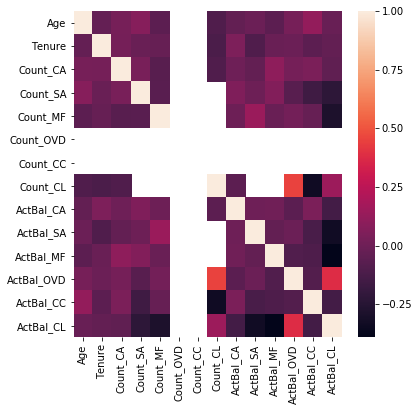

In [24]:
plt.figure(figsize= (6, 6))
sn.heatmap(train_final.loc[:,"Age":"ActBal_CL"].corr())


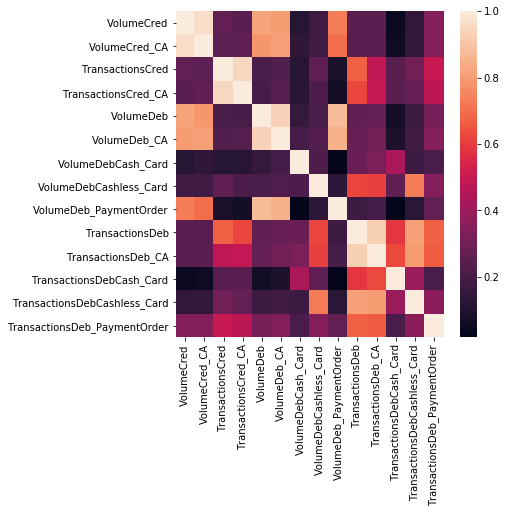

In [25]:
plt.figure(figsize= (6, 6))
sn.heatmap(target_final.loc[:,"VolumeCred":"TransactionsDeb_PaymentOrder"].corr())

Observations from correlation heatmap:
- Count_OVD and Count_CC were highly correlated with every feature
- VolumeCred is highly correlated with VolumeCred_CA
- TransactionsCred seem highly correlated with TransactionsCred_CA
- VolumeDeb is also highly correlated with VolumeDeb_CA
- TransactionsDeb is highly correlated with TransactionsDeb_CA

Base on the meta data, VolumeCred, TransactionsCred, VolumeDeb and TransactionsDeb are global or general. They are highly correlated with features which are specific.

### 2.2 Visualization for sales and revenue

Data visualization on the labeled data will give a distribution of clients with sales and revenue information. 

In [20]:
#Creation of dataframe of ownership frequency for each bank product
sales_freq_df = p.DataFrame({"Ownership":[0,1],"Sale_MF":list(train_final['Sale_MF'].value_counts()),
                              "Sale_CC":list(train_final['Sale_CC'].value_counts()),
                              "Sale_CL":list(train_final['Sale_MF'].value_counts())})
sales_freq_df.set_index("Ownership", inplace=True)
sales_freq_df

,Sale_MF,Sale_CC,Sale_CL
Ownership,,,
0,776,727,776
1,193,242,193


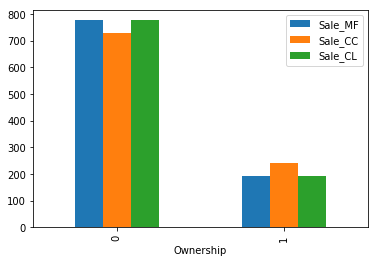

In [28]:
sales_freq_df.plot(kind="bar")

<div class="alert alert-block alert-info">
<b>First business insight:</b> The bar plot above shows that there are more clients who don't own 3 of the bank products than those who do own. There are more clients who own a credit card than those who own a mutual fund and consumer loan. However, there are less people without a credit card than a consumer loan and mutual fund
</div>


In [133]:
revenue_df = train_final.loc[:,["Client","Revenue_MF","Revenue_CC", "Revenue_CL","Sale_MF","Sale_CC","Sale_CL"]]
#revenue_df.set_index("Client", inplace=True)
revenue_df.head()

,Client,Revenue_MF,Revenue_CC,Revenue_CL,Sale_MF,Sale_CC,Sale_CL
0,1094,0.000000,5.138571,0.0000,0,1,0
1,1484,25.609107,0.000000,8.7225,1,0,1
2,20,0.000000,3.822500,0.0000,0,1,0
3,1193,0.000000,0.000000,0.0000,0,0,0
4,142,0.000000,0.000000,0.0000,0,0,0


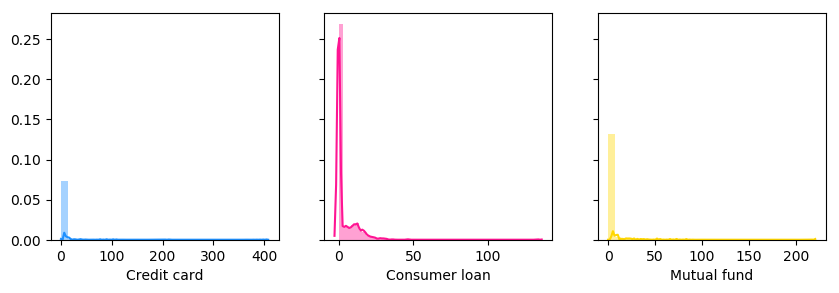

In [53]:
#Distribution plot for revenue per bank product
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sn.distplot(revenue_df.loc[:,"Revenue_CC"] , color="dodgerblue", ax=axes[0], axlabel='Credit card')
sn.distplot(revenue_df.loc[:,"Revenue_CL"] , color="deeppink", ax=axes[1], axlabel='Consumer loan')
sn.distplot(revenue_df.loc[:,"Revenue_MF"] , color="gold", ax=axes[2], axlabel='Mutual fund')

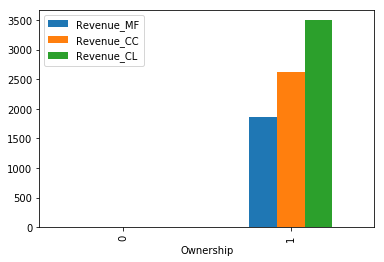

In [55]:
#Creation of dataframe having revenue sums per ownership
revenue_tot_df = p.DataFrame({"Ownership":[0,1],
                              "Revenue_MF":[sum(list(revenue_df.Revenue_MF.loc[revenue_df.Sale_MF==0])),sum(list(revenue_df.Revenue_MF.loc[revenue_df.Sale_MF==1]))],
                              "Revenue_CC":[sum(list(revenue_df.Revenue_CC.loc[revenue_df.Sale_CC==0])),sum(list(revenue_df.Revenue_CC.loc[revenue_df.Sale_CC==1]))],
                              "Revenue_CL":[sum(list(revenue_df.Revenue_CL.loc[revenue_df.Sale_CL==0])),sum(list(revenue_df.Revenue_CL.loc[revenue_df.Sale_CL==1]))]})
revenue_tot_df.set_index("Ownership", inplace=True)
revenue_tot_df.plot(kind="bar")

<div class="alert alert-block alert-info">
<b>Second business insight:</b> The distribution of revenue from probability plot show a highly positive skew, indicate that the strategy of revenue (positive measurement) generation wasn't efficient enough. An ideal probability plot would be need to be normally distributed but this might be unrealistic as there would always be customers with and without a bank product. This is due to more clients who don't own a bank product can't generate revenue. It is obvious that clients who don't own a bank product won't contribute to the revenue as seen in the bar plot. People who own a consumer loan generate more revenue compared to the other products (credit card and mutual fund)
</div>


# FEATURE ENGINEERING AND TRANSFORMATION

This was necessary to improve the quality of the data which will lead to a high performing model. Every method applied here was applied on the train set. However, the target set was only handled here for missing data because the predictive models can't make predictions on data that has missing data.

The methods used here include
1. **Handling missing observation:** Missing data needed to be taken care of as this could introduce bias to the models and reduce the efficiency of subsequent analysis. Missing data in the quantitative features were imputed with their medians and the qualitative feature (Sex) was imputed with its mode.
2. **Dummy variable creation:** Sex feature was the only categorication feature in the train set. 2 dummy features were created out of this "Sex" feature using binary coding
3. **Handling outliers:** Removing outliers could possibly help remove bias in the prediction analysis. The outliers here were replaced with the limits of the respective feature distributions 
4. **Feature normalization:** During the the descriptive statistics of the train set, it was noted that certain features don't have a consistent scale. The features were normalized to a scale of 0-1. However, the train set which was normalised led to a poor performing model. Therefore, the only processed train set from the 3rd preprocessing step was eventually used to train the propensity and revenue models

In [6]:
#Train sets
train_MF = train_final.loc[:,['Client','Sale_MF', 'Revenue_MF','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]
train_CL = train_final.loc[:,['Client','Sale_CL', 'Revenue_CL','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]
train_CC = train_final.loc[:,['Client','Sale_CC', 'Revenue_CC','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]

#Target sets
target_MF = target_final.loc[:,['Client','Sale_MF', 'Revenue_MF','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]
target_CL = target_final.loc[:,['Client','Sale_CL', 'Revenue_CL','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]
target_CC = target_final.loc[:,['Client','Sale_CC', 'Revenue_CC','Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']]

## 1. Handling missing observations

In [7]:
#Imputation of the zero ages with the mean age on train set
train_MF["Age"]=train_MF["Age"].replace(0,train_MF["Age"].median())
train_CL["Age"]=train_CL["Age"].replace(0,train_CL["Age"].median())
train_CC["Age"]=train_CC["Age"].replace(0,train_CC["Age"].median())

#Imputation of the zero ages with the mean age on target set
target_MF["Age"]=target_MF["Age"].replace(0,target_MF["Age"].median())
target_CL["Age"]=target_CL["Age"].replace(0,target_CL["Age"].median())
target_CC["Age"]=target_CC["Age"].replace(0,target_CC["Age"].median())

It can be observed that there exist two missing observations in "sex" and >50% of the data was missing in "count_CA", "count_SA", "count_MF", "count_OVD","count_CC", "count_CL","ActBal_CA", "ActBal_SA", "ActBal_MF", "ActBal_OVD","ActBal_CC", "ActBal_CL"

In [8]:
train_MF.head()

,Client,Sale_MF,Revenue_MF,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1094,0,0.000000,M,25,8,1,NaN,NaN,NaN,...,1366.313929,1366.313929,53.571429,351.950357,891.327857,31.0,31.0,1.0,21.0,4.0
1,1484,1,25.609107,M,39,0,1,NaN,NaN,NaN,...,768.625000,768.625000,107.142857,302.446429,357.785714,23.0,23.0,1.0,16.0,5.0
2,20,0,0.000000,M,27,181,1,1.0,NaN,NaN,...,221.428571,221.428571,107.142857,10.714286,103.571429,7.0,7.0,3.0,1.0,3.0
3,1193,0,0.000000,M,48,16,2,NaN,NaN,1.0,...,1661.201071,1207.906429,507.142857,331.150000,75.178571,55.0,36.0,6.0,21.0,2.0
4,142,0,0.000000,F,27,183,1,NaN,NaN,NaN,...,728.107143,728.107143,0.000000,0.000000,725.928571,2.0,2.0,0.0,0.0,1.0


In [9]:
#Number of missing data per variable in train set
missing_df = p.DataFrame(train_final.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['Missing'])
missing_df

,Missing
ActBal_CL,890
Count_CL,890
Count_CC,859
ActBal_CC,859
Count_MF,785
ActBal_MF,785
Count_OVD,718
ActBal_OVD,718
Count_SA,704
ActBal_SA,704


In [66]:
#Number of missing data per variable test set
missing_df = p.DataFrame(target_final.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['Missing'])
missing_df

,Missing
ActBal_CL,590
Count_CL,590
Count_CC,586
ActBal_CC,586
Count_MF,524
ActBal_MF,524
Count_SA,485
ActBal_SA,485
Count_OVD,478
ActBal_OVD,478


In [9]:
#Imputing the missing observations in the "Sex" variable with mode in train sets
train_MF["Sex"] = train_MF["Sex"].fillna(statistics.mode(train_MF['Sex']))
train_CC["Sex"] = train_CC["Sex"].fillna(statistics.mode(train_CC['Sex']))
train_CL["Sex"] = train_CL["Sex"].fillna(statistics.mode(train_CL['Sex']))

#Imputing the missing observations in the "Sex" variable with mode in test sets
target_MF["Sex"] = target_MF["Sex"].fillna(statistics.mode(target_MF['Sex']))
target_CC["Sex"] = target_CC["Sex"].fillna(statistics.mode(target_CC['Sex']))
target_CL["Sex"] = target_CL["Sex"].fillna(statistics.mode(target_CL['Sex']))

In [10]:
#Imputing the missing observations in each feature based on ownership group in train set with median
sel_cols=list(train_final)[8:36]
all_data = [train_MF, train_CC, train_CL]
all_sales = ["Sale_MF","Sale_CC", "Sale_CL"]
for d in range(0, len(all_data)):
    for i in range(0,len(sel_cols)):
        all_data[d].loc[all_data[d][sel_cols[i]].isnull(), sel_cols[i]] = all_data[d].groupby(all_sales[d])[sel_cols[i]].transform('median')

In [11]:
#Check if imputation was successful in the train set
missing_df = p.DataFrame(train_MF.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['MF'])
missing_df["CC"] = p.DataFrame(train_CC.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['CC'])["CC"]
missing_df["CL"] = p.DataFrame(train_CL.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['CL'])["CL"]
missing_df

,MF,CC,CL
TransactionsDeb_PaymentOrder,0,0,0
ActBal_CC,0,0,0
Age,0,0,0
Tenure,0,0,0
Count_CA,0,0,0
Count_SA,0,0,0
Count_MF,0,0,0
Count_OVD,0,0,0
Count_CC,0,0,0
Count_CL,0,0,0


In [12]:
#Imputing the missing observations in each feature based on ownership in target set
sel_cols=list(target_final)[3:30]
data_sets = [target_MF, target_CL, target_CC]
for data in data_sets:
    for col in sel_cols:
        data[col]=data[col].replace(nan,data[col].median())

In [13]:
#Check if imputation was successful in the target set
missing_df = p.DataFrame(target_MF.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['MF'])
missing_df["CC"] = p.DataFrame(target_CC.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['CC'])["CC"]
missing_df["CL"] = p.DataFrame(target_CL.loc[:,"Sex":"TransactionsDeb_PaymentOrder"].isnull().sum().sort_values(ascending=False),columns=['CL'])["CL"]
missing_df

,MF,CC,CL
TransactionsDeb_PaymentOrder,0,0,0
ActBal_CC,0,0,0
Age,0,0,0
Tenure,0,0,0
Count_CA,0,0,0
Count_SA,0,0,0
Count_MF,0,0,0
Count_OVD,0,0,0
Count_CC,0,0,0
Count_CL,0,0,0


## 2. Dummy variable creation

In [14]:
#Creation of dummy variables in the train set
dummy_train_MF = p.get_dummies(train_MF['Sex'])
dummy_train_CL = p.get_dummies(train_CL['Sex'])
dummy_train_CC = p.get_dummies(train_CC['Sex'])
dummy_train_MF.head()

,F,M
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0


In [15]:
#Creation of dummy variables in the target set
dummy_target_MF = p.get_dummies(target_MF['Sex'])
dummy_target_CL = p.get_dummies(target_CL['Sex'])
dummy_target_CC = p.get_dummies(target_CC['Sex'])
dummy_target_MF.head()

,F,M
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


## 3. Handling outliers


Indentifying which variables have outliers using boxplot. Only "Tenure","Age","Count_CC","Count_OVD" had no outlier

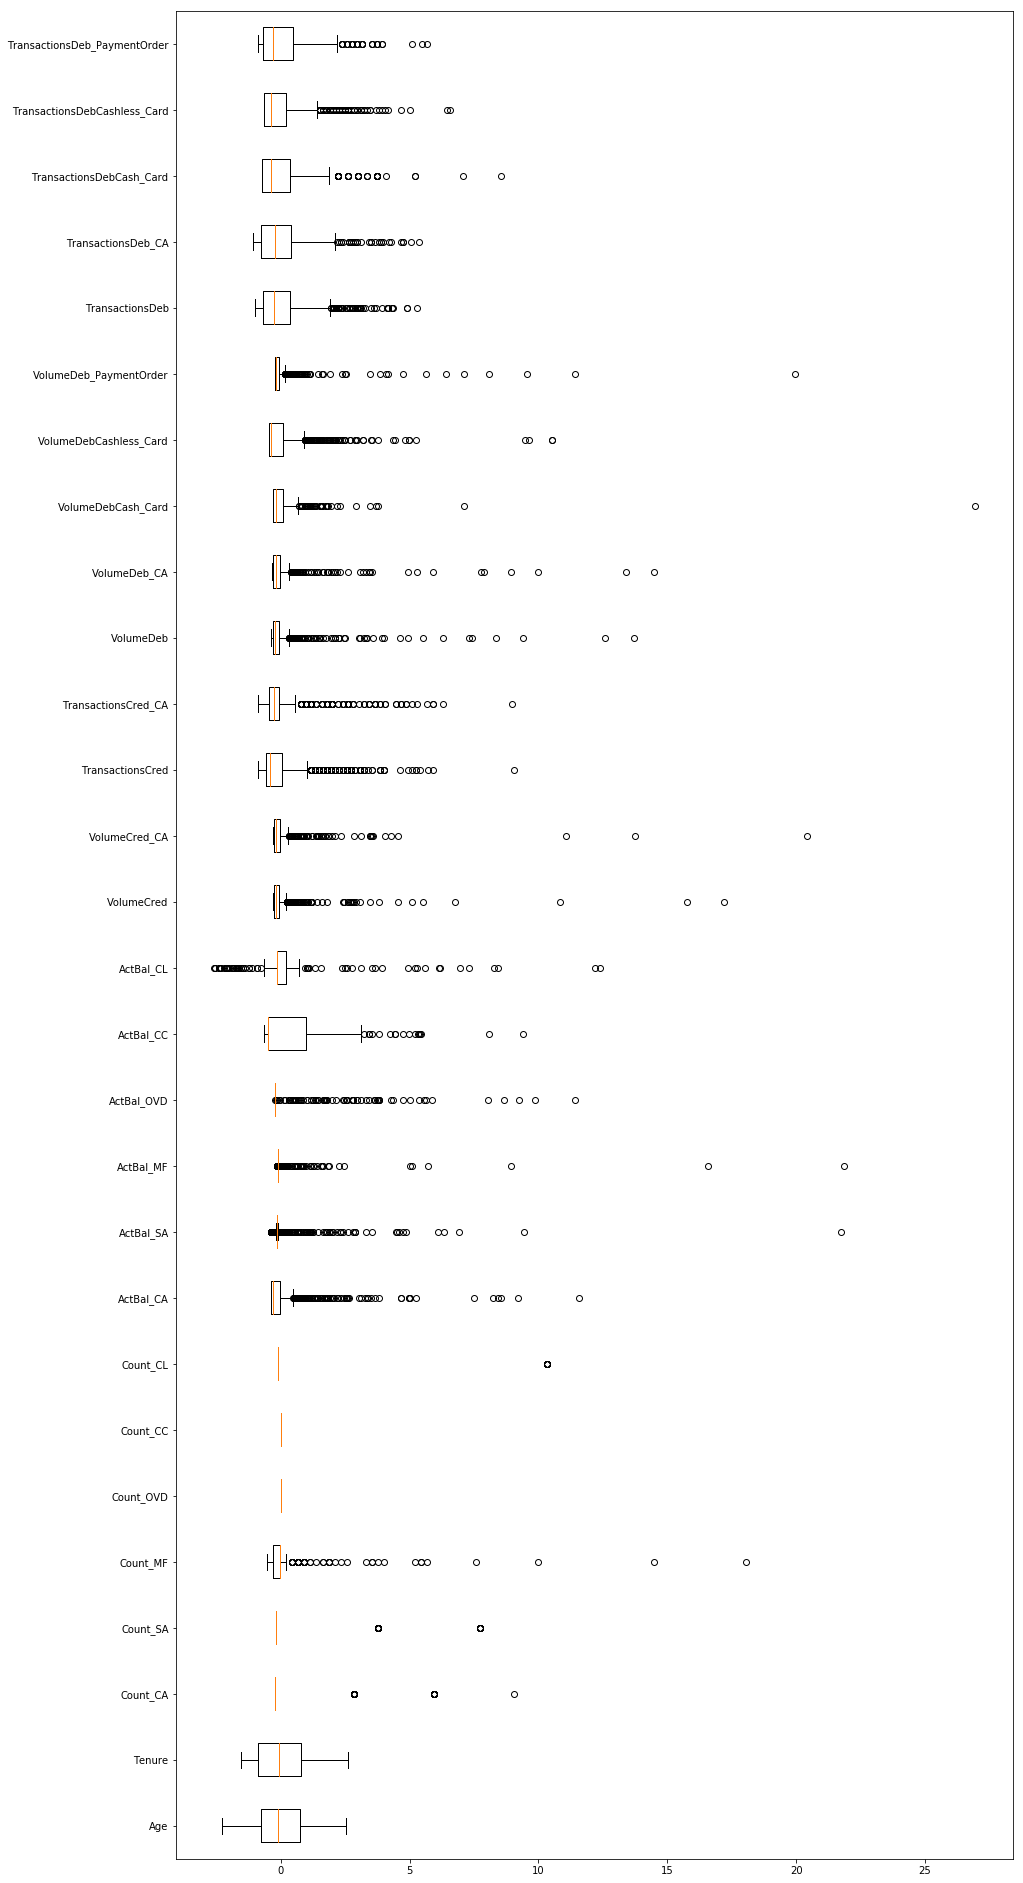

In [14]:
#Box plot creation
trainCC_bp = train_CC.select_dtypes(exclude=['object']).copy()
trainCC_bp2 = trainCC_bp.drop(['Client','Sale_CC', 'Revenue_CC'], axis=1)
data_scaled = scale(trainCC_bp2 )

# Create a figure instance
fig = plt.figure(1, figsize=(15, 34))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bxlabs=list(trainCC_bp2)

# Create the boxplot
bp = ax.boxplot(data_scaled,labels=bxlabs,showfliers=True,vert=False)
plt.show()

In [16]:
##########################################################################
################ Creation of truncation function #########################
############################################################################
#This is a method used to handle outliers where they are imputed with the maximum value (if higher than the maximum value)
# and minimum value (if higher than the minimum value)
#The function takes a feature as input
def truncate(Ys):
    
    Q1 = Ys.quantile(0.25)  #First quartile 
    Q3 = Ys.quantile(0.75)  #Third quartile
    IQR = Q3 - Q1           #Interquartile range
    upper_bound =  Q3 + (1.5 * IQR)    #Upper limit
    lower_bound = Q1 - (1.5 * IQR)       #Lower limit
    
    #Imputing the outliers with upper and lower limit
    value_outlier_Y_up = Ys > upper_bound  
    value_outlier_Y_low = Ys < lower_bound
    outlier_listUB=len(Ys[value_outlier_Y_up])
    outlier_listLB=len(Ys[value_outlier_Y_low])
    if outlier_listUB != 0:
        Ys = Ys.replace([Ys[value_outlier_Y_up]], upper_bound)
    if outlier_listLB != 0:
        Ys = Ys.replace([Ys[value_outlier_Y_low]], lower_bound) 
    
    return Ys

In [17]:
#Applying the truncation function on the feature variables
vars_outliers=[ 'Count_CA', 'Count_SA',
                'Count_MF','Count_CL','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC',
                'ActBal_CL','VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
                'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb', 'TransactionsDeb_CA',
                'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
for i in range(0,len(vars_outliers)):
    train_CL[vars_outliers[i]]=truncate(train_CL[vars_outliers[i]])
    
for i in range(0,len(vars_outliers)):
    train_CC[vars_outliers[i]]=truncate(train_CC[vars_outliers[i]])
    
for i in range(0,len(vars_outliers)):
    train_MF[vars_outliers[i]]=truncate(train_MF[vars_outliers[i]])

In [17]:
warnings.filterwarnings("ignore")

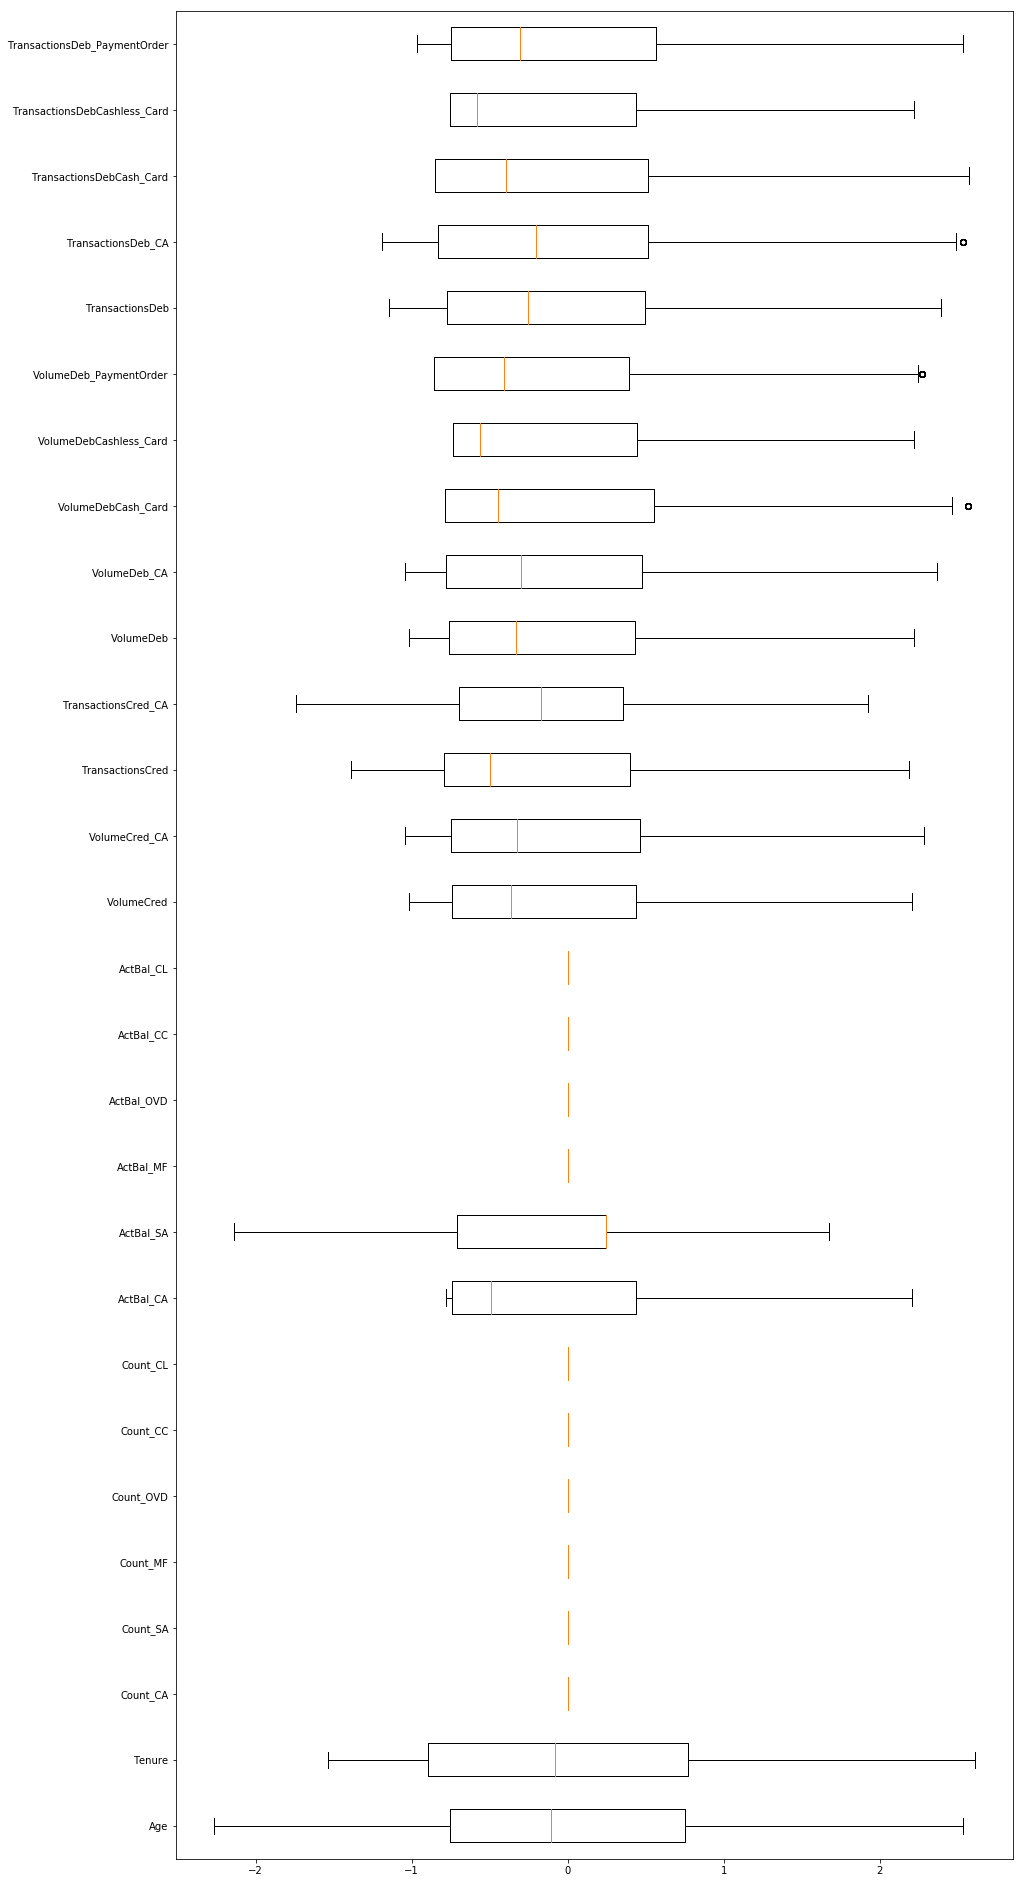

In [18]:
#Creation of boxplot after applying truncation function on the features
data_bp = train_MF.select_dtypes(exclude=['object']).copy()
data_bp2 = data_bp.drop(['Client','Sale_MF','Revenue_MF'], axis=1)
data_scaled = scale(data_bp2 )

# Create a figure instance
fig = plt.figure(1, figsize=(15, 34))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bxlabs=list(data_bp2)

# Create the boxplot
bp = ax.boxplot(data_scaled,labels=bxlabs,showfliers=True,vert=False)
plt.show()

## 4. Feature normalisation

In [147]:
train_MF.describe()

,Client,Sale_MF,Revenue_MF,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,969.000000,969.000000,969.000000,969.000000,969.000000,969.0,969.0,969.0,969.0,969.0,...,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,814.781218,0.199174,1.925015,43.027847,100.393189,1.0,1.0,2.0,1.0,1.0,...,997.191632,907.708661,207.546461,112.660043,330.285006,15.378225,13.245614,1.867905,4.432405,4.409701
std,464.568139,0.399586,9.943601,18.527460,65.437097,0.0,0.0,0.0,0.0,0.0,...,982.864669,872.049741,264.031501,153.583625,386.851441,13.421821,11.145615,2.193056,5.887401,4.576524
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0,2.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,422.000000,0.000000,0.000000,29.000000,42.000000,1.0,1.0,2.0,1.0,1.0,...,250.881071,226.647500,0.000000,0.000000,0.005000,5.000000,4.000000,0.000000,0.000000,1.000000
50%,819.000000,0.000000,0.000000,41.000000,95.000000,1.0,1.0,2.0,1.0,1.0,...,674.137500,648.606071,89.285714,26.471429,171.964286,12.000000,11.000000,1.000000,1.000000,3.000000
75%,1216.000000,0.000000,0.000000,57.000000,151.000000,1.0,1.0,2.0,1.0,1.0,...,1421.702143,1324.642857,353.571429,181.307143,483.178571,22.000000,19.000000,3.000000,7.000000,7.000000
max,1615.000000,1.000000,220.488214,90.000000,271.000000,1.0,1.0,2.0,1.0,1.0,...,3177.933750,2971.635893,883.928571,453.267857,1207.938929,47.500000,41.500000,7.500000,17.500000,16.000000


In [19]:
# Scaling the continuous features to the same scale
min_max_scaler = preprocessing.MinMaxScaler()
features = ['Age','Tenure','Count_CA', 'Count_SA','Count_MF','Count_CL','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC',
                'ActBal_CL','VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
                'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb', 'TransactionsDeb_CA',
                'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']

train_MF_sc = train_MF.loc[:,["Client","Sale_MF", "Revenue_MF"]]
train_CC_sc = train_CC.loc[:,["Client","Sale_CC", "Revenue_CC"]]
train_CL_sc = train_CL.loc[:,["Client","Sale_CL", "Revenue_CL"]]
all_data = [train_MF, train_CC, train_CL]
all_data_sc = [train_MF_sc, train_CC_sc, train_CL_sc]

for d in range(0,len(all_data_sc)):
    for feature in features:
        all_data_sc[d][feature] = p.DataFrame(min_max_scaler.fit_transform(p.DataFrame(train_MF[feature],columns=[feature])), columns=[feature])[feature]


In [39]:
train_MF_sc.loc[:,"Age":"ActBal_CL"].describe()

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,969.000000,969.000000,969.0,969.0,969.0,969.0,969.000000,969.000000,969.0,969.0,969.0,969.0
mean,0.472200,0.370455,0.0,0.0,0.0,0.0,0.262122,0.561092,0.0,0.0,0.0,0.0
std,0.208175,0.241465,0.0,0.0,0.0,0.0,0.334735,0.262298,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.314607,0.154982,0.0,0.0,0.0,0.0,0.013188,0.375000,0.0,0.0,0.0,0.0
50%,0.449438,0.350554,0.0,0.0,0.0,0.0,0.096822,0.625000,0.0,0.0,0.0,0.0
75%,0.629213,0.557196,0.0,0.0,0.0,0.0,0.407913,0.625000,0.0,0.0,0.0,0.0
max,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0


In [40]:
train_MF_sc.loc[:,"VolumeCred":"TransactionsDeb_PaymentOrder"].describe()

,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,0.315764,0.312936,0.388889,0.475601,0.313786,0.305458,0.234800,0.248551,0.273429,0.323752,0.319171,0.249054,0.253280,0.275606
std,0.309892,0.300742,0.279833,0.272958,0.309278,0.293458,0.298702,0.338836,0.320257,0.282565,0.268569,0.292407,0.336423,0.286033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086533,0.087126,0.166667,0.285714,0.078945,0.076270,0.000000,0.000000,0.000004,0.105263,0.096386,0.000000,0.000000,0.062500
50%,0.202923,0.216046,0.250000,0.428571,0.212131,0.218266,0.101010,0.058401,0.142362,0.252632,0.265060,0.133333,0.057143,0.187500
75%,0.451920,0.452275,0.500000,0.571429,0.447367,0.445762,0.400000,0.400000,0.400002,0.463158,0.457831,0.400000,0.400000,0.437500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
train_MF_sc2 = train_MF_sc.drop(['Count_CA', 'Count_SA', 'Count_MF', 'Count_CL', 'ActBal_MF', 'ActBal_OVD',
                                 'ActBal_CC', 'ActBal_CL' ], axis=1)
train_CL_sc2 = train_CL_sc.drop(['Count_CA', 'Count_SA', 'Count_MF', 'Count_CL', 'ActBal_MF', 'ActBal_OVD',
                                 'ActBal_CC', 'ActBal_CL' ], axis=1)
train_CC_sc2 = train_CC_sc.drop(['Count_CA', 'Count_SA', 'Count_MF', 'Count_CL', 'ActBal_MF', 'ActBal_OVD',
                                 'ActBal_CC', 'ActBal_CL' ], axis=1)

# MODEL TRAINING

This section was structured as follows:

- Pre-model feature selection

- **Consumer loan, Credit card** and **Mutual fund models**:

    1.1 Full propensity model
    
    1.2 Reduced propensity model
    
    2.1 Full revenue model
    
    2.2 Reduced revenue model
    
The full models were trained with all the features excluding those eliminated based on the information obtained from the exploratory analysis. Whereas, the reduced model constitutes features selected via recursive feature elimination algorithm. In each case (full and reduced models), the models were trained using hyper-parameter tuning and 10-fold cross validation. The propensity models were evaluated with test sets using the AUC, precision, relay and F1-score. While the revenue models were evaluated with RMSE and R$^{2}$

### Pre-model feature selection

Prior to normalization of the data, features Count_CA, Count_SA, Count_MF, Count_CL, ActBal_OVD, ActBal_CC and ActBal_CL have zero standard deviation. These features have little to no information to contribute to the predictive models. Therefore, these less informative features can already be removed. 

Also, the global or general features(VolumeCred, TransactionsCred, VolumeDeb and TransactionsDeb) from the correlation heatmap which were highly correlated with their respective specific features (VolumeCred_CA, TransactionsCred_CA, VolumeDeb_CA and TransactionsDeb_CA). Base on the meta data of this features, they seem to have vary overlapping information which makes them also very similar. Therefore, these general features can be taken off and the specific features were retained. 

## CONSUMER LOAN

In [265]:
#All features from the consumer loan data set
print(list(train_CL))

['Client', 'Sale_CL', 'Revenue_CL', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']


### Full propensity model for consumer loan

In [21]:
################################# FULL PROPENSITY MODEL #################################################

#Selection of features with high information
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL', 'VolumeCred_CA',
              'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
CL_X= train_CL.loc[:,features_X]
CL_X['Female'] = dummy_train_CL['F']
CL_X['Male'] = dummy_train_CL['M']

#Selection of target
CL_Y=train_CL.loc[:,["Sale_CL"]]

#Splitting into train and test set
trainCL_X, testCL_X, trainCL_y, testCL_y = train_test_split(CL_X, CL_Y, test_size=0.2, random_state=12)

#Training the classifier using grid search (Hyperparameter tuning)
CL_RF = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15]}
grid_CL_full = GridSearchCV(CL_RF, param_grid, cv=10)
grid_CL_full.fit(trainCL_X, trainCL_y)

#Generalization performance of full model
print("AUC : ",roc_auc_score(testCL_y,grid_CL_full.predict(testCL_X)))

AUC :  0.9846153846153847


### Reduced propensity model for consumer loan

In [22]:
#Applying recursive feature selection using 10-fold cross-validation
selector_CL_red = RFECV(grid_CL_full.best_estimator_, step=1, cv=5)
selector_CL_red = selector_CL_red.fit(trainCL_X, trainCL_y)
feat_names = list(CL_X)
print("Features choosen")
print(list(compress(feat_names, selector_CL_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'TransactionsDeb_CA']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [23]:
################################# REDUCED PROPENSITY MODEL #################################################

#Creation of feature set with the selected features
features_CL_prop_red = list(compress(feat_names, selector_CL_red.support_))
CL_X2= CL_X.loc[:,features_CL_prop_red]


#Selection of target
CL_Y2=train_CL.loc[:,["Sale_CL"]]

#Splitting into train and test set
trainCL_X2, testCL_X2, trainCL_y2, testCL_y2 = train_test_split(CL_X2, CL_Y2, test_size=0.2, random_state=12)

#Training the classifier using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15]}
grid_CL_reduce = GridSearchCV(CL_RF, param_grid, cv=10)
grid_CL_reduce.fit(trainCL_X2, trainCL_y2)

#Generalisation performance of the reduced model
print("AUC: ",roc_auc_score(testCL_y2,grid_CL_reduce.predict(testCL_X2)))

AUC:  0.9846153846153847


The generalization performance of the reduced and full models have the same generalisation performance. Therefore, either of these models will be used to predict the propensity of the clients to have a consumer loan

In [114]:
#Preceision and recall for random forest
print(classification_report(testCL_y2, grid_CL_reduce.predict(testCL_X2)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       129
          1       1.00      0.97      0.98        65

avg / total       0.99      0.99      0.99       194



### Full revenue model for consumer loan

This part of the analysis involves determining the expected revenue from having a consumer loan. A model will be trained on the train set and then used to predict the revenue on the test set.

In [25]:
CL_X_rev.head()

,Age,Tenure,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_CL,VolumeCred_CA,TransactionsCred_CA,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Female,Male
0,0.269663,0.029520,0.016052,0.625,NaN,NaN,0.000004,0.142857,0.459785,0.060606,0.776473,0.737891,0.746988,0.133333,1.000000,0.2500,0,1
1,0.426966,0.000000,0.000000,0.375,NaN,NaN,0.472251,0.714286,0.258654,0.121212,0.667258,0.296195,0.554217,0.133333,0.914286,0.3125,0,1
2,0.292135,0.667897,0.395704,1.000,NaN,NaN,0.157366,0.428571,0.074514,0.121212,0.023638,0.085742,0.168675,0.400000,0.057143,0.1875,0,1
3,0.528090,0.059041,0.753857,0.625,NaN,NaN,0.401353,1.000000,0.406479,0.573737,0.730583,0.062237,0.867470,0.800000,1.000000,0.1250,0,1
4,0.292135,0.675277,0.272584,0.625,NaN,NaN,0.248930,0.142857,0.245019,0.000000,0.000000,0.600965,0.048193,0.000000,0.000000,0.0625,1,0


In [27]:
#Creation of the feature set
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL', 
              'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',  
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
CL_X_rev= train_CL.loc[:,features_X]
CL_X_rev['Female'] = dummy_train_CL['F']
CL_X_rev['Male'] = dummy_train_CL['M']

#Selection of target
CL_Y_rev=train_CL.loc[:,["Revenue_CL"]]

#Splitting into train and test set
trainCL_X_rev, testCL_X_rev, trainCL_y_rev, testCL_y_rev = train_test_split(CL_X_rev, CL_Y_rev, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15]}
RFR_CL_rev = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_CL_rev_full = GridSearchCV(RFR_CL_rev, param_grid, cv=10)
grid_RFR_CL_rev_full.fit(trainCL_X_rev, trainCL_y_rev)

#Generalization performance of full model
print( "RMSE : ",math.sqrt(mean_squared_error(testCL_y_rev, grid_RFR_CL_rev_full.predict(testCL_X_rev))))

RMSE :  4.069314855565987


### Reduced revenue model for consumer loan

In [28]:
#Applying recursive feature selection on the full revenue model
selector_CL_rev_red = RFECV(grid_RFR_CL_rev_full.best_estimator_, step=1, scoring='neg_mean_squared_error', cv=5)
selector_CL_rev_red = selector_CL_rev_red.fit(trainCL_X_rev, trainCL_y_rev)
feat_names = list(CL_X)
print("Features choosen")
print(list(compress(feat_names, selector_CL_rev_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['ActBal_CL']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [30]:
#Creation of the feature set
features_CL_rev_red =list(compress(feat_names, selector_CL_rev_red.support_))
CL_X_rev2= CL_X_rev.loc[:,features_CL_rev_red]

#Selection of target
CL_Y_rev2=train_CL.loc[:,"Revenue_CL"]

#Splitting into train and test set
trainCL_X_rev2, testCL_X_rev2, trainCL_y_rev2, testCL_y_rev2 = train_test_split(CL_X_rev2, CL_Y_rev2, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15]}
RFR_CL_rev = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_CL_rev_red = GridSearchCV(RFR_CL_rev, param_grid, cv=10)
grid_RFR_CL_rev_red.fit(trainCL_X_rev2, trainCL_y_rev2)

#Generalization performance of reduced model
print("RMSE: ",math.sqrt(mean_squared_error(testCL_y_rev2, grid_RFR_CL_rev_red.predict(testCL_X_rev2))))

RMSE:  4.698700105900913


The MSE of the smaller model was higher than that of the full model. Therefore, the expected revenues of consumer products will be determined using the full model

### Prediction of expected revenues and propensities to buy  consumer loan

In [31]:
target_CL["Female"] = dummy_train_CL['F']
target_CL["Male"] = dummy_train_CL['M']
clients = target_CL['Client']
probabilities = grid_CL_reduce.predict_proba(target_CL.loc[:,features_CL_prop_red])[:,1]
revenues = list(grid_RFR_CL_rev_full.predict(target_CL.loc[:,list(CL_X_rev)]))
Clients_CL = p.DataFrame({"Client":clients,
                         "Prob_CL":probabilities,
                         "Revenue_CL":revenues})

#Top clients with highest propensity to own consumer loan
Clients_CL = Clients_CL.loc[Clients_CL.Prob_CL>0.5,:].sort_values(by=["Prob_CL"],ascending=False)
Clients_CL.head()

,Client,Prob_CL,Revenue_CL
547,1482,1.000000,9.472540
516,401,0.999487,11.676148
199,331,0.998311,9.221663
375,803,0.998311,8.709135
61,154,0.997691,10.933772


## CREDIT CARD

### Full propensity model for credit card

In [33]:
#Selection of features with high information
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL',
              'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',  
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
CC_X= train_CC.loc[:,features_X]
CC_X['Female'] = dummy_train_CC['F']
CC_X['Male'] = dummy_train_CC['M']

#Selection of target 
CC_Y=train_CC["Sale_CC"]

#Splitting into train and test set
trainCC_X, testCC_X, trainCC_y, testCC_y = train_test_split(CC_X, CC_Y, test_size=0.2, random_state=12)

#Training the classifier using grid search (Hyperparameter tuning)
CC_RF = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15]}
grid_CC_RF_full = GridSearchCV(CC_RF, param_grid, cv=10)
grid_CC_RF_full.fit(trainCC_X, trainCC_y)

#Generalization performance of full model
print("AUC : ",roc_auc_score(testCC_y, grid_CC_RF_full.predict(testCC_X)))

AUC :  0.9891304347826086


### Reduced propensity model for credit card

In [34]:
#Recursive feature selection for propensity model for credit card
selector_CC_red = RFECV(grid_CC_RF_full.best_estimator_, step=1, cv=5)
selector_CC_red = selector_CC_red.fit(trainCC_X, trainCC_y)
feat_names = list(CC_X)
print("Features choosen")
print(list(compress(feat_names, selector_CC_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'VolumeDeb_CA', 'TransactionsDebCash_Card']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [36]:
#Creation of the feature set
features_CC_red = list(compress(feat_names, selector_CC_red.support_))
CC_X_red= CC_X.loc[:,features_CC_red]

#Selection of target
CC_Y_red=train_CC.loc[:,"Sale_CC"]

#Splitting into train and test set
trainCC_X2, testCC_X2, trainCC_y2, testCC_y2 = train_test_split(CC_X_red, CC_Y_red, test_size=0.2, random_state=12)

#Training the classifier using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [2, 4, 8, 12]}
CC_RF = RandomForestClassifier(random_state=0)
grid_CC_reduced = GridSearchCV(CC_RF, param_grid, cv=10)
grid_CC_reduced.fit(trainCC_X2, trainCC_y2)

#Generalization performance for reduced model
print("AUC: ",roc_auc_score(testCC_y2, grid_CC_reduced.predict(testCC_X2)))

AUC:  0.9891304347826086


In [122]:
#Preceision and recall for ensemble classifier
print(classification_report(testCC_y2,grid_CC_reduced.predict(testCC_X2)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       148
          1       1.00      0.98      0.99        46

avg / total       0.99      0.99      0.99       194



## Full revenue model for credit card

In [37]:
#Creation of the feature set
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL', 
              'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
CC_X_rev= train_CC.loc[:,features_X]
CC_X_rev['Female'] = dummy_train_CC['F']
CC_X_rev['Male'] = dummy_train_CC['M']

#Selection of target
CC_Y_rev=train_CC.loc[:,["Revenue_CC"]]

#Splitting into train and test set
trainCC_X_rev, testCC_X_rev, trainCC_y_rev, testCC_y_rev = train_test_split(CC_X_rev, CC_Y_rev, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15], "min_samples_split" : [2,4,8]}
RFR_CC = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_CC_rev_full = GridSearchCV(RFR_CC, param_grid, cv=10)
grid_RFR_CC_rev_full.fit(trainCC_X_rev, trainCC_y_rev)

#Generalization performance of full model
print("RMSE: ", math.sqrt(mean_squared_error(testCC_y_rev, grid_RFR_CC_rev_full.predict(testCC_X_rev))))

RMSE:  14.586122763388515


##  Reduced revenue model for credit card 

In [38]:
selector_CC_rev_red = RFECV(grid_RFR_CC_rev_full.best_estimator_, step=1, cv=10,scoring='neg_mean_squared_error')
selector_CC_rev_red = selector_CC_rev_red.fit(trainCC_X_rev, trainCC_y_rev)
feat_names = list(CC_X)
print("Features choosen")
print(list(compress(feat_names, selector_CC_rev_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['Tenure', 'ActBal_CL', 'VolumeDeb_PaymentOrder']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [40]:
#Creation of the feature set
features_CC_rev_red = list(compress(feat_names, selector_CC_rev_red.support_))
CC_X_rev2= CC_X_rev.loc[:,features_CC_rev_red]

#Selection of target
CC_Y_rev2=train_CC.loc[:,"Revenue_CC"]

#Splitting into train and test set
trainCC_X_rev2, testCC_X_rev2, trainCC_y_rev2, testCC_y_rev2 = train_test_split(CC_X_rev2, CC_Y_rev2, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [3,5,7,12], "min_samples_split" : [2,4,8]}
RFR_CC_rev = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_CC_rev_reduced = GridSearchCV(RFR_CC_rev, param_grid, cv=10)
grid_RFR_CC_rev_reduced.fit(trainCC_X_rev2, trainCC_y_rev2)

#Generalisation performance of the reduced model
print("RMSE: ",math.sqrt(mean_squared_error(testCC_y_rev2,grid_RFR_CC_rev_reduced.predict(testCC_X_rev2))))

RMSE:  15.214478194571223


The full revenue model for credit card has a better generalisation performance than that of the reduced model. Therefore the full model was used to predict the expected revenues of credit card holders

### Prediction of expected revenues and propensities to buy credit cards

In [41]:
target_CC["Female"] = dummy_train_CC['F']
target_CC["Male"] = dummy_train_CC['M']
clients = target_CC['Client']
probabilities = grid_CC_reduced.predict_proba(target_CC.loc[:,list(CC_X_red)])
revenues = list(grid_RFR_CC_rev_full.predict(target_CC.loc[:,list(CC_X_rev)]))
Clients_CC = p.DataFrame({"Client":clients,
                         "Prob_CC":probabilities[:,1],
                         "Revenue_CC":revenues})
#Top clients with highest propensity to own a credit card
Clients_CC = Clients_CC.loc[Clients_CC.Prob_CC>0.5,:].sort_values(by=["Prob_CC"],ascending=False)
Clients_CC.head()

,Client,Prob_CC,Revenue_CC
497,1424,0.982546,5.985689
307,283,0.929871,13.825626
89,382,0.929871,14.849856
372,839,0.929871,12.109192
28,1380,0.929871,14.213756


# 3)Mutual fund

## Full propensity model for mutual fund

In [42]:
#Selection of features with high information
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL',
              'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',  
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
MF_X= train_MF.loc[:,features_X]
MF_X['Female'] = dummy_train_MF['F']
MF_X['Male'] = dummy_train_MF['M']

#Selection of target
MF_Y=train_MF["Sale_MF"]

#Splitting into train and test set
trainMF_X, testMF_X, trainMF_y, testMF_y = train_test_split(MF_X, MF_Y, test_size=0.2, random_state=12)

#Training the classifier using grid search (Hyperparameter tuning)
MF_RF = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15], "min_samples_split" : [2,4,8]}
grid_MF_RF_full = GridSearchCV(MF_RF, param_grid, cv=10)
grid_MF_RF_full.fit(trainMF_X, trainMF_y)

#Generalization performance of full model
print("AUC : ",roc_auc_score(testMF_y, grid_MF_RF_full.predict(testMF_X)))

AUC :  0.9125494921673265


## Reduced propensity model for mutual fund 

In [43]:
#Recursive feature elimination on best full model
selector_MF_red = RFECV(grid_MF_RF_full.best_estimator_, step=1, cv=5)
selector_MF_red = selector_MF_red.fit(trainMF_X, trainMF_y)
feat_names = list(MF_X)
print("Features choosen")
print(list(compress(feat_names, selector_MF_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred_CA', 'VolumeDeb_CA', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDeb_PaymentOrder']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [45]:
#Creation of the feature set
features_MF_red = list(compress(feat_names, selector_MF_red.support_))
MF_X_red= MF_X.loc[:,features_MF_red]

#Selection of target
MF_Y_red=train_MF.loc[:,"Sale_MF"]

#Splitting into train and test set
trainMF_X2, testMF_X2, trainMF_y2, testMF_y2 = train_test_split(MF_X_red, MF_Y_red, test_size=0.2, random_state=12)


#Training the classifier using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [2, 4, 8, 12], "min_samples_split" : [2,4,8]}
MF_RF = RandomForestClassifier(random_state=0)
grid_MF_reduced = GridSearchCV(MF_RF, param_grid, cv=10)
grid_MF_reduced.fit(trainMF_X2,  trainMF_y2)

#Generalization performance of reduced model
print("AUC: ",roc_auc_score(testMF_y2, grid_MF_reduced.predict(testMF_X2)))

AUC:  0.9157342055431227


The generalization performance of the reduced model is better than that of the full model. Therefore, the reduced model was used to select the high propensity to buy a mutual fund

In [132]:
#Preceision and recall for logistic regression
print(classification_report(testMF_y2,grid_MF_reduced.predict(testMF_X2)))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98       157
          1       0.97      0.84      0.90        37

avg / total       0.96      0.96      0.96       194



## Full revenue model for mutual fund

In [67]:
#Creation of the feature set
features_X = ['Age','Tenure','ActBal_CA', 'ActBal_SA','ActBal_MF','ActBal_CL',
              'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',
              'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 
              'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
              'TransactionsDeb_PaymentOrder']
MF_X_rev= train_MF.loc[:,features_X]
MF_X_rev['Female'] = dummy_train_MF['F']
MF_X_rev['Male'] = dummy_train_MF['M']

#Selection of target
MF_Y_rev=train_MF.loc[:,["Revenue_MF"]]

#Splitting into train and test set
trainMF_X_rev, testMF_X_rev, trainMF_y_rev, testMF_y_rev = train_test_split(MF_X_rev, MF_Y_rev, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15],"min_samples_split" : [2,4,8]}
RFR_MF = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_MF_rev_full = GridSearchCV(RFR_MF, param_grid, cv=10)
grid_RFR_MF_rev_full.fit(trainMF_X_rev, trainMF_y_rev)

#Generalization performance of full model
print("RMSE: ",math.sqrt(mean_squared_error(testMF_y_rev, grid_RFR_MF_rev_full.predict(testMF_X_rev))))

RMSE:  17.039060552726507


## Reduced revenue model for mutual fund

In [47]:
#Recursive feature selection on best full model
selector_MF_rev_red = RFECV(grid_RFR_MF_rev_full.best_estimator_, step=1, cv=5,scoring='neg_mean_squared_error')
selector_MF_rev_red = selector_MF_rev_red.fit(MF_X_rev, MF_Y_rev)
feat_names = list(MF_X)
print("Features choosen")
print(list(compress(feat_names, selector_MF_rev_red.support_)))
print("")
print("All features")
print(feat_names)

Features choosen
['Age', 'ActBal_SA']

All features
['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_CL', 'VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Female', 'Male']


In [54]:
#Creation of the feature set
features_MF_rev_red = list(compress(feat_names, selector_MF_rev_red.support_))
MF_X_rev2= MF_X_rev.loc[:,features_MF_rev_red]

#Selection of target
MF_Y_rev2=train_MF.loc[:,"Revenue_MF"]

#Splitting into train and test set
trainMF_X_rev2, testMF_X_rev2, trainMF_y_rev2, testMF_y_rev2 = train_test_split(MF_X_rev2, MF_Y_rev2, test_size=0.2, random_state=12)

#Training the random forest regression model using grid search (Hyperparameter tuning)
param_grid = {'n_estimators': [20, 50, 70, 100],'max_depth': [5, 7, 10, 15],"min_samples_split" : [2,4,8]}
RFR_MF_rev = RandomForestRegressor(random_state=0, verbose=0)
grid_RFR_MF_rev_reduced = GridSearchCV(RFR_MF_rev, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_RFR_MF_rev_reduced.fit(trainMF_X_rev2, trainMF_y_rev2)

#Generalization performance of reduced model
print("RMSE: ",math.sqrt(mean_squared_error(testMF_y_rev2,grid_RFR_MF_rev_reduced.predict(testMF_X_rev2))))

RMSE:  16.869854008279162


### Prediction of expected revenues and propensities to buy mutual fund

In [55]:
#Creation of dataframe with predicted propensities and expected revenues
target_MF["Female"] = dummy_train_MF['F']
target_MF["Male"] = dummy_train_MF['M']
clients = target_MF['Client']
probabilities = grid_MF_RF_full.predict_proba(target_MF.loc[:,list(testMF_X)])
revenues = list(grid_RFR_MF_rev_reduced.predict(target_MF.loc[:,list(MF_X_rev2)]))
Clients_MF = p.DataFrame({"Client":clients,
                         "Prob_MF":probabilities[:,1],
                         "Revenue_MF":revenues})
#Top clients with highest propensity to own mutual fund
Clients_MF = Clients_MF.sort_values(by=["Prob_MF"],ascending=False)
Clients_MF = Clients_MF.loc[Clients_MF.Prob_MF>0.5,:]
Clients_MF.head()

,Client,Prob_MF,Revenue_MF
332,379,0.657143,1.335057
284,1097,0.642857,2.491589
230,772,0.614286,1.382291
479,760,0.585714,3.131779
346,781,0.585714,9.184835


# TARGET CLIENTS

The clients with high propensity to own a bank product were used here to maximize their respective expected revenues. 

In [57]:
print("Number of clients with high propensity to own consumer loan :",len(Clients_CL))
print("Number of clients with high propensity to own credit card :",len(Clients_CC))
print("Number of clients with high propensity to own mutual fund :",len(Clients_MF))

Number of clients with high propensity to own consumer loan : 634
Number of clients with high propensity to own credit card : 608
Number of clients with high propensity to own mutual fund : 14


In [63]:
#Creation of dataframe with all propensities and revenues for each bank product
CLCC_Clients=p.merge(Clients_CL,Clients_CC,on='Client',how='outer')
Final_Clients=p.merge(CLCC_Clients,Clients_MF,on='Client',how='outer')
Final_Clients[630:640]

,Client,Prob_CL,Revenue_CL,Prob_CC,Revenue_CC,Prob_MF,Revenue_MF
630,166,0.521039,4.982016,0.537967,5.157597,NaN,NaN
631,246,0.516709,6.297203,NaN,NaN,NaN,NaN
632,1097,0.515700,10.195622,NaN,NaN,0.642857,2.491589
633,690,0.502668,7.337302,NaN,NaN,NaN,NaN
634,834,NaN,NaN,0.576758,5.157597,NaN,NaN
635,994,NaN,NaN,0.562161,5.201565,NaN,NaN
636,97,NaN,NaN,0.537656,4.970290,NaN,NaN
637,829,NaN,NaN,0.533822,5.157597,NaN,NaN
638,39,NaN,NaN,0.529043,5.157597,NaN,NaN
639,1606,NaN,NaN,0.518114,5.201565,NaN,NaN


The dataframe above shows that certain clients were predicted to have more than 1 bank product. However, the bank can contact a client only once with an offer. In the following cells, the maximization approach here will involve choosing the bank product with the highest expected revenue. Then, the these maximum revenues ordered in ascending order (highest to lowest). Since the bank can only contact 15% of its clients with a marketing offer, the first 100 clients with maximum expected revenues are selected. 

In [58]:
#Preparing dataframe of only expected revenues per bank product to maximize
Revenues = Final_Clients.loc[:,['Client','Revenue_CL','Revenue_CC','Revenue_ML']]
Revenues.set_index("Client", inplace=True)
Revenue_df = p.DataFrame(Revenues.loc[:,['Revenue_CL','Revenue_CC','Revenue_ML']].idxmax(axis=1), columns=["Product"])


In [59]:
#Creation of data frame with products having maximum expected revenue
Revenue_df["Max_revenue"] = Revenues.max(axis=1)
Revenue_df = Revenue_df.sort_values(by=["Max_revenue"],ascending=False)[0:100]
Revenue_df.head()

,Product,Max_revenue
Client,,
1389,Revenue_CC,78.353991
1073,Revenue_CC,76.165967
153,Revenue_CC,74.008066
1162,Revenue_CC,71.499209
1365,Revenue_CC,71.291056


In [60]:
#Distribution of high propensity clients across products
Revenue_df["Product"].value_counts()

Revenue_CC    94
Revenue_CL     6
Name: Product, dtype: int64

In [62]:
#Sum up of the maximum revenues
plot_prod_rev = Revenue_df.loc[:,["Product","Max_revenue"]].groupby("Product").sum() 
plot_prod_rev

,Max_revenue
Product,
Revenue_CC,3294.253703
Revenue_CL,229.881446


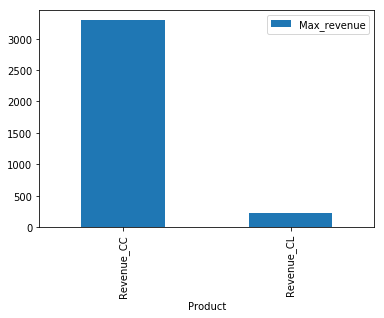

In [161]:
plot_prod_rev.plot(kind='bar')

<div class="alert alert-block alert-info">
<b>Third business insight:</b> There are more clients with high propensity to purchase a bank loan than credit card followed by mutual fund. However, based on maximazing the expected revenue and the banks marketing policy to contact clients with a bank offer, the bank should contact clients with credit card and consumer loans. 
</div>

In [68]:
#Saving the clients with high propensity to bye a product
meta_data = p.DataFrame({"Sheet name":["Contact these clients", "Consumer loan clients","Credit card clients","Mutual fund clients"],
                        "Description":["List of clients with maximum revenue and high propensity to buy a product. Revenue_CC(credit card) and Revenue_CL(consumer loan)","List of clients with high propensity to purchase a consumer loan","List of clients with high propensity to purchase a credit card","List of clients with propensity to purchase a mutual fund"]
                        })
Revenue_df.reset_index(inplace=True)
writer = p.ExcelWriter("C:/Users/eugen/Desktop/Work/KBC bank/Clients.xlsx")
meta_data.to_excel(writer,'Description')
Revenue_df.loc[:,["Client","Product"]].to_excel(writer,"Contact these clients")
Clients_CL['Client'].to_excel(writer, "Consumer loan clients")
Clients_CC['Client'].to_excel(writer, "Credit card clients")
Clients_MF['Client'].to_excel(writer, "Mutual fund clients")
writer.save()